## 页面版式分析并绘图的函数

In [14]:
# 初始化环境变量
from dotenv import load_dotenv
load_dotenv()
# 初始化 PDF文件路径
# file_path = "../../90-文档_Data/山西文旅/云冈石窟-ch.pdf"
# file_path = "../../90-文档_Data/test/xiaomi14.pdf"
file_path = "../../90-文档_Data/test/zte-report-simple.pdf"

#### 1. 渲染指定PDF页面并绘制段落分类框 函数

In [15]:
import fitz  # PyMuPDF库，用于处理PDF文件
import matplotlib.patches as patches  # 用于在图像上绘制多边形
import matplotlib.pyplot as plt  # Matplotlib库，用于绘图
from PIL import Image  # 用于图像处理

def render_pdf_page(file_path, doc_list, page_number):
    """
    渲染指定PDF页面并绘制段落分类框。

    参数：
    - file_path: str，PDF文件路径。
    - doc_list: list，包含段落信息的文档列表，每个元素是一个字典，包含段落元数据。
    - page_number: int，要渲染的页面号（从1开始计数）。
    """
    # 打开PDF文件并加载指定页面
    pdf_page = fitz.open(file_path).load_page(page_number - 1)
    segments = [doc.metadata for doc in doc_list if doc.metadata.get("page_number") == page_number]

    # 将PDF页面渲染为位图图像
    pix = pdf_page.get_pixmap()
    pil_image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    # 创建绘图环境
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(pil_image)

    # 定义类别颜色映射
    category_to_color = {"Title": "orchid", "Image": "forestgreen", "Table": "tomato"}
    categories = set()

    # 绘制段落标注框
    for segment in segments:
        points = segment["coordinates"]["points"]
        layout_width = segment["coordinates"]["layout_width"]
        layout_height = segment["coordinates"]["layout_height"]
        scaled_points = [
            (x * pix.width / layout_width, y * pix.height / layout_height) for x, y in points
        ]
        box_color = category_to_color.get(segment["category"], "deepskyblue")
        categories.add(segment["category"])
        rect = patches.Polygon(scaled_points, linewidth=1, edgecolor=box_color, facecolor="none")
        ax.add_patch(rect)

    # 添加图例
    legend_handles = [patches.Patch(color="deepskyblue", label="Text")]
    for category, color in category_to_color.items():
        if category in categories:
            legend_handles.append(patches.Patch(color=color, label=category))
    ax.axis("off")
    ax.legend(handles=legend_handles, loc="upper right")
    plt.tight_layout()
plt.show()

#### 2. 用Unstructured解析文档

In [24]:
from langchain_unstructured import UnstructuredLoader
import pprint
import os

loader = UnstructuredLoader(
    file_path=file_path,
    strategy="hi_res",
    partition_via_api=True,  # 通过API调用Unstructured
    coordinates=True,  # 返回元素位置坐标
    api_key=os.getenv("UNSTRUCTURED_API_KEY"),
    infer_table_structure=True,  # 推断表格结构
    extract_images=True,  # 提取图像
    image_format="png",  # 图像格式
    include_metadata=True,  # 包含元数据
)
docs = []
for doc in loader.lazy_load():
    docs.append(doc)

for doc in docs[:5]:
    pprint.pprint(doc.model_dump())

INFO: HTTP Request: GET https://api.unstructuredapp.io/general/docs "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"


{'id': None,
 'metadata': {'category': 'NarrativeText',
              'coordinates': {'layout_height': 2339,
                              'layout_width': 1654,
                              'points': [[241.39999999999998,
                                          198.84127807617188],
                                         [241.39999999999998,
                                          278.03155555555526],
                                         [1418.498779296875,
                                          278.03155555555526],
                                         [1418.498779296875,
                                          198.84127807617188]],
                              'system': 'PixelSpace'},
              'element_id': '86f9baea0c3a1d1673d23caff99bf267',
              'filename': 'zte-report-simple.pdf',
              'filetype': 'application/pdf',
              'languages': ['eng'],
              'page_number': 1,
              'source': '../../90-文档_Data/test/zte-report

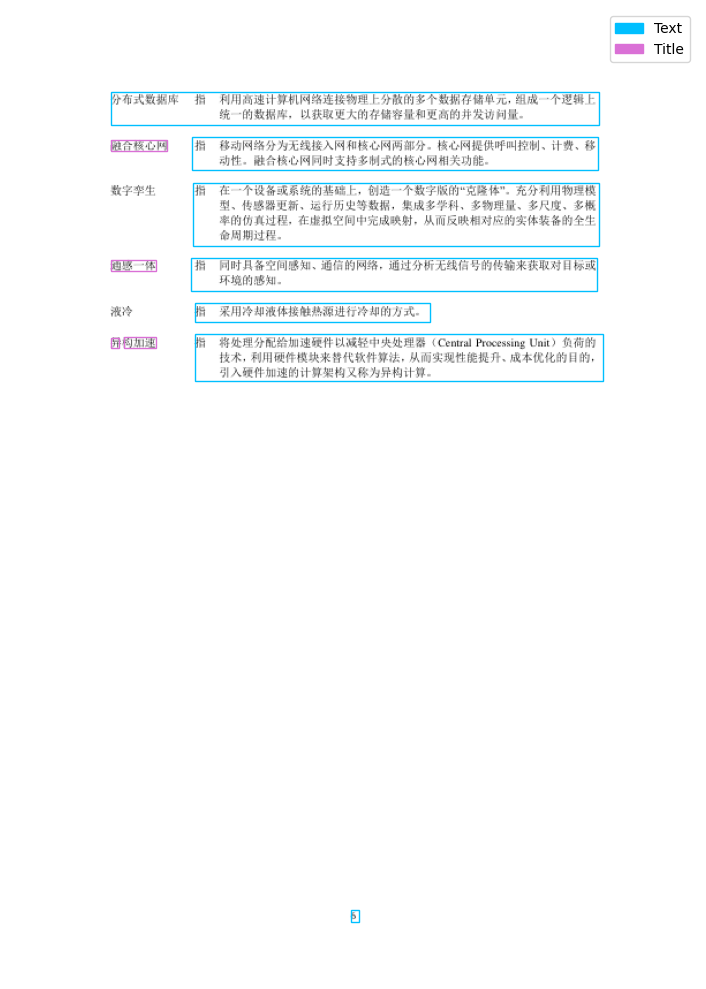

In [17]:
render_pdf_page(file_path, docs, 1)

#### 3. 仅筛选第一页的 Doc

In [18]:
page_number = 1
page_docs = [doc for doc in docs if doc.metadata.get("page_number") == page_number]

# 遍历并打印每个 Doc 的详细信息
for i, doc in enumerate(page_docs, 1):
    print(f"Doc {i}:")
    print(f"  内容: {doc.page_content}")
    print(f"  分类: {doc.metadata.get('category')}")
    print(f"  ID: {doc.metadata.get('element_id')}")
    print(f"  Parent ID: {doc.metadata.get('parent_id')}")
    print(f"  位置: {doc.metadata.get('position')}")
    print(f"  坐标: {doc.metadata.get('coordinates')}")
    print("=" * 50)

Doc 1:
  内容: 分布式数据库 指 利用高速计算机网络连接物理上分散的多个数据存储单元，组成一个逻辑上 统一的数据库，以获取更大的存储容量和更高的并发访问量。
  分类: NarrativeText
  ID: 86f9baea0c3a1d1673d23caff99bf267
  Parent ID: None
  位置: None
  坐标: {'points': [[241.39999999999998, 198.84127807617188], [241.39999999999998, 278.03155555555526], [1418.498779296875, 278.03155555555526], [1418.498779296875, 198.84127807617188]], 'system': 'PixelSpace', 'layout_width': 1654, 'layout_height': 2339}
Doc 2:
  内容: [ A
  分类: Title
  ID: a3c0f48d2c4612cbd2da0d8f7cab3ef1
  Parent ID: None
  位置: None
  坐标: {'points': [[243.0, 314.0], [243.0, 340.0], [377.0, 340.0], [377.0, 314.0]], 'system': 'PixelSpace', 'layout_width': 1654, 'layout_height': 2339}
Doc 3:
  内容: k
  分类: Title
  ID: c1c71ac6ada261f2c0468a4ed4b8ce97
  Parent ID: None
  位置: None
  坐标: {'points': [[242.0, 605.0], [242.0, 630.0], [351.0, 630.0], [351.0, 605.0]], 'system': 'PixelSpace', 'layout_width': 1654, 'layout_height': 2339}
Doc 4:
  内容: S
  分类: Title
  ID: 84dba1bd14d18dbfef9cc31141407921
  Parent ID:

#### 4. 解析文档并列出所有Title

In [19]:
titles = [doc.page_content for doc in docs if doc.metadata.get("category") == "Title"]

# 输出Title
print("本PDF中的 Title 包括：")
for i, title in enumerate(titles, 1):
    print(f"{i}. {title}")

本PDF中的 Title 包括：
1. [ A
2. k
3. S
4. A g
5. 董事长致辞
6. 尊敬的各位股东：
7. 第一章 公司简介和主要财务数据摘要
8. 1.1 公司简介
9. 1.1.1 公司信息
10. 1.1.4 联系人及联系方式
11. 1.1.5 信息披露及备置地点
12. 1.1.6 中介信息
13. 1.2 主要财务数据摘要
14. 1.2.1 采用的会计准则说明
15. 1.2.4 本集团 2023 年分季度主要财务指标
16. 第二章 董事会报告
17. 2.1 2023 年核心技术创新
18. 2.1.1 坚持长期投入，掌控底层核心技术
19. 1、芯片领域
20. 2、数据库领域
21. 3、操作系统领域


#### 5. 解析Title与Text的对应关系

In [22]:
from IPython.core.display import HTML

# 仅筛选第一页的 Title
page_number = 2
title_dict = {}

# 收集 Title，并建立 parent_id -> Title 的映射
for doc in docs:
    if doc.metadata.get("category") == "Title" and doc.metadata.get("page_number") == page_number:
        title_id = doc.metadata.get("element_id")  # Title 的唯一 ID
        title_text = f"<h3 style='color: magenta;'>{doc.page_content}</h3>"
        title_dict[title_id] = {"title": title_text, "content": []}

# 关联 Title 和其对应的 Text
for doc in docs:
    if (doc.metadata.get("category") == "Text" or doc.metadata.get("category") == "NarrativeText") and doc.metadata.get("page_number") == page_number:
        parent_id = doc.metadata.get("parent_id")  # 这个 Text 归属于哪个 Title
        if parent_id in title_dict:
            title_dict[parent_id]["content"].append(doc.page_content)

# 组合输出 HTML
combined_html = ""
for title_data in title_dict.values():
    content_html = "<p>" + "</p><p>".join(title_data["content"]) + "</p>"
    combined_html += f"{title_data['title']}{content_html}<br>"

# 在 Jupyter Notebook 中显示格式化的输出
display(HTML(combined_html))

#### 6. 解析图片附近的文本

In [23]:
import numpy as np

# 仅筛选第一页的 Image
page_number = 2
images = [doc for doc in docs if doc.metadata.get("category") == "Image" and doc.metadata.get("page_number") == page_number]

# 计算图片附近的文本
for i, image in enumerate(images, 1):
    image_box = np.array(image.metadata.get("coordinates", {}).get("points", []))

    # 如果没有坐标信息，则跳过
    if image_box.size == 0:
        continue

    # 计算图片的中心位置
    image_center_x = np.mean(image_box[:, 0])
    image_center_y = np.mean(image_box[:, 1])
    
    # 找到最近的文本
    nearby_texts = []
    for doc in docs:
        if doc.metadata.get("category") in ["Text", "Title"] and doc.metadata.get("page_number") == page_number:
            text_box = np.array(doc.metadata.get("coordinates", {}).get("points", []))
            if text_box.size == 0:
                continue

            # 计算文本的中心位置
            text_center_x = np.mean(text_box[:, 0])
            text_center_y = np.mean(text_box[:, 1])

            # 计算欧几里得距离
            distance = np.sqrt((text_center_x - image_center_x) ** 2 + (text_center_y - image_center_y) ** 2)

            # 设定合理的距离阈值，例如 300 以内的文本视为相邻
            if distance < 300:
                nearby_texts.append(doc.page_content)

    # 输出第一页图片附近的文本
    print(f"\n第一页图片 {i} 附近的文本：")
    print("\n".join(nearby_texts) if nearby_texts else "无相关文本")


第一页图片 1 附近的文本：
无相关文本
